In [1]:
import argparse
import os
from dataset.anomaly_dataset import (
    AnomalyDetecionDataset,
    load_dataset_from_path,
)
import torch
import torch.nn.functional as TF
from torch.utils.data import DataLoader
from torchvision import transforms 
from tqdm import tqdm

from resnet import wide_resnet50_2

import numpy as np

from einops import rearrange

/home/ysh/.conda/envs/mcdd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataloader(data_path, gt_path):
    # set dataset transforms.
    data_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            # transforms.Normalize(mean=mean_train, std=std_train),
        ]
    )
    gt_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    train_dataset = AnomalyDetecionDataset(
        data_path,
        *load_dataset_from_path(data_path, [["good"], []], gt_path, True),
        transform=data_transforms,
        gt_transform=gt_transforms,
    )
    train_loader = DataLoader(
        train_dataset, batch_size=1, shuffle=False, num_workers=4
    )
    return train_loader

In [3]:
data_path = "/mnt/hdd/Project-DAC/data/PN23_DAC_Silver/SI_06/augmentation/train"
gt_path = "/mnt/hdd/Project-DAC/data/PN23_DAC_Silver/SI_06/augmentation/ground_truth"
ckpt = ".result/231108_vae_simple_betalearning_patch/models/best.pt"
save_path = ".result/231108_vae_simple_betalearning_patch/result/best"
device = 1
SAMPLING_PATCHES = 100000

In [4]:
os.makedirs(save_path, exist_ok=True)
train_loader = get_dataloader(data_path, gt_path)

In [5]:
patch_size=16
ignore_neighbor=2

GI_NP = []
BI_NP = []
BI_AP = []
BI_AP_WEAK = []

GI_NP_masks = []
BI_NP_masks = []
BI_AP_masks = []
BI_AP_WEAK_masks = []
for x, gt, y, file_name in tqdm(train_loader, ncols=79, desc="Sampling"):
    patchwise_gt = (
        TF.unfold(gt, kernel_size=patch_size, stride=patch_size)
        .sum(dim=-2)
        .reshape(gt.shape[0],-1, gt.shape[-2]//patch_size, gt.shape[-1]//patch_size)
        )
    if ignore_neighbor != 0:
        normal_mask = (
            TF.max_pool2d(
                patchwise_gt,
                kernel_size=2 * ignore_neighbor + 1,
                stride=1,
                padding=ignore_neighbor
            ) == 0
        )
    else:
        normal_mask = patchwise_gt == 0

    defect_mask = patchwise_gt >= 7
    weak_defect_mask = patchwise_gt < 7
    normal_mask = rearrange(normal_mask, "b c h w -> (b h w) c").squeeze(dim=1)
    defect_mask = rearrange(defect_mask, "b c h w -> (b h w) c").squeeze(dim=1)
    weak_defect_mask = rearrange(weak_defect_mask, "b c h w -> (b h w) c").squeeze(dim=1)
    if y[0] == 0:
        GI_NP_masks.append(normal_mask.detach().cpu().numpy())
        BI_NP_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
        BI_AP_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
        BI_AP_WEAK_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
    else:
        GI_NP_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
        BI_NP_masks.append(normal_mask.detach().cpu().numpy())
        BI_AP_masks.append(defect_mask.detach().cpu().numpy())
        BI_AP_WEAK_masks.append(weak_defect_mask.detach().cpu().numpy())


print("GI NP length :", len(GI_NP_masks))
print("BI NP length :", len(BI_NP_masks))
print("BI AP length :", len(BI_AP_masks))
print("BI AP(weak) length :", len(BI_AP_WEAK_masks))

Sampling: 100%|██████████████████████████████| 816/816 [00:10<00:00, 79.07it/s]

GI NP length : 816
BI NP length : 816
BI AP length : 816
BI AP(weak) length : 816


In [6]:


nPatches = [ m.size for m in GI_NP_masks]
masks = np.concatenate(GI_NP_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    GI_NP_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        GI_NP_masks.append(m)

nPatches = [ m.size for m in BI_NP_masks]
masks = np.concatenate(BI_NP_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    BI_NP_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        BI_NP_masks.append(m)

nPatches = [ m.size for m in BI_AP_masks]
masks = np.concatenate(BI_AP_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    BI_AP_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        BI_AP_masks.append(m)

nPatches = [ m.size for m in BI_AP_WEAK_masks]
masks = np.concatenate(BI_AP_WEAK_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    BI_AP_WEAK_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        BI_AP_WEAK_masks.append(m)

print("GI NP length :", len(GI_NP_masks))
print("BI NP length :", len(BI_NP_masks))
print("BI AP length :", len(BI_AP_masks))
print("BI AP(weak) length :", len(BI_AP_WEAK_masks))

GI NP length : 816
BI NP length : 816
BI AP length : 816
BI AP(weak) length : 816


In [7]:
from models.vae_simple import VAE
from torchinfo import summary
device = torch.device(device)
model = VAE(
    in_channel=1,
    hidden_channels=[32, 64, 128],
    latent_dim=128,
    in_shape=(16, 16)
)
model.load_state_dict(torch.load(ckpt, map_location="cpu"))
model.to(device)
summary(model, (1, 1, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 1, 16, 16]            --
├─Sequential: 1-1                        [1, 128, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 32, 8, 8]             544
│    └─BatchNorm2d: 2-2                  [1, 32, 8, 8]             64
│    └─LeakyReLU: 2-3                    [1, 32, 8, 8]             --
│    └─Dropout: 2-4                      [1, 32, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 64, 4, 4]             32,832
│    └─BatchNorm2d: 2-6                  [1, 64, 4, 4]             128
│    └─LeakyReLU: 2-7                    [1, 64, 4, 4]             --
│    └─Dropout: 2-8                      [1, 64, 4, 4]             --
│    └─Conv2d: 2-9                       [1, 128, 2, 2]            131,200
│    └─BatchNorm2d: 2-10                 [1, 128, 2, 2]            256
│    └─LeakyReLU: 2-11                   [1, 128, 2, 2]            --
│  

In [8]:
model.eval()
for i, (x, gt, y, file_name),  in enumerate(tqdm(train_loader, ncols=79, desc="Featuring")):
    x = x.to(device)
    with torch.no_grad():
        embedding = None
        h1 = int((x.shape[-2] - patch_size)/patch_size + 1)
        w1 = int((x.shape[-1] - patch_size)/patch_size + 1)
        patches = TF.unfold(
            x.mean(dim=1, keepdim=True),
            kernel_size=patch_size,
            stride=patch_size
        )
        patches = rearrange(
            patches,
            "b (h2 w2) (h1 w1) -> (b h1 w1) 1 h2 w2",
            h2=patch_size,
            w2=patch_size,
            h1=h1,
            w1=w1
        )

        mu, logvar = model.encode(patches)
        
        embedding = mu.clone()

    GI_NP.append(embedding[GI_NP_masks[i]].detach().cpu().numpy())
    BI_NP.append(embedding[BI_NP_masks[i]].detach().cpu().numpy())
    BI_AP.append(embedding[BI_AP_masks[i]].detach().cpu().numpy())
    BI_AP_WEAK.append(embedding[BI_AP_WEAK_masks[i]].detach().cpu().numpy())

GI_NP = np.concatenate(GI_NP, axis=0)
BI_NP = np.concatenate(BI_NP, axis=0)
BI_AP = np.concatenate(BI_AP, axis=0)
BI_AP_WEAK = np.concatenate(BI_AP_WEAK, axis=0)

Featuring: 100%|█████████████████████████████| 816/816 [00:09<00:00, 87.81it/s]


In [9]:
print("GI NP length :", len(GI_NP))
print("BI NP length :", len(BI_NP))
print("BI AP length :", len(BI_AP))
print("BI AP(weak) length :", len(BI_AP_WEAK))

GI NP length : 100000
BI NP length : 100000
BI AP length : 52978
BI AP(weak) length : 100000


In [10]:
total_features = np.concatenate([GI_NP, BI_NP, BI_AP, BI_AP_WEAK], axis=0)
label_text = ["GI_NP", "BI_NP", "BI_AP", "BI_AP_WEAK"]
label_color = ["green", "blue", "red", "orange"]
total_labels = np.concatenate([
        0*np.ones((len(GI_NP),), dtype=np.int32),
        0*np.ones((len(BI_NP),), dtype=np.int32),
        1*np.ones((len(BI_AP),), dtype=np.int32),
        2*np.ones((len(BI_AP_WEAK),), dtype=np.int32)
    ],
    axis=0
)

In [11]:
print(total_features.shape)
print(total_labels.shape)

(352978, 128)
(352978,)


In [14]:
import pickle

with open(os.path.join(save_path, "features_preproc.npy"), "wb") as f:
    pickle.dump(
        (total_features, total_labels, 2),
        f
    )

In [16]:
np.load(os.path.join(save_path, "features_preproc.npy"), allow_pickle=True)

(array([[-0.0965148 ,  0.06743205, -0.00523091, ...,  0.0493943 ,
          0.06640236, -0.04801459],
        [-0.03523917,  0.01966415, -0.02322561, ...,  0.01933789,
          0.02274924,  0.0024936 ],
        [ 0.0637596 , -0.05661501, -0.00185516, ..., -0.03470812,
         -0.05109471,  0.06016617],
        ...,
        [ 0.01215592,  0.01085164,  0.07022233, ..., -0.00114122,
         -0.03648397, -0.01121982],
        [-0.0273181 ,  0.02621071,  0.05486237, ...,  0.03667225,
         -0.0227894 , -0.07435951],
        [-0.02100663,  0.00402034, -0.04982397, ..., -0.01035004,
         -0.03764288,  0.03777914]], dtype=float32),
 array([0, 0, 0, ..., 2, 2, 2], dtype=int32),
 2)

In [80]:
from sklearn.manifold import Isomap, TSNE
import pickle

transformer = Isomap(n_neighbors=50)
emb_features = transformer.fit_transform(total_features)

with open(os.path.join(save_path, "Isomap-features.pkl"), "wb") as f:
    pickle.dump(
        (emb_features, total_labels, label_text),
        f
    )


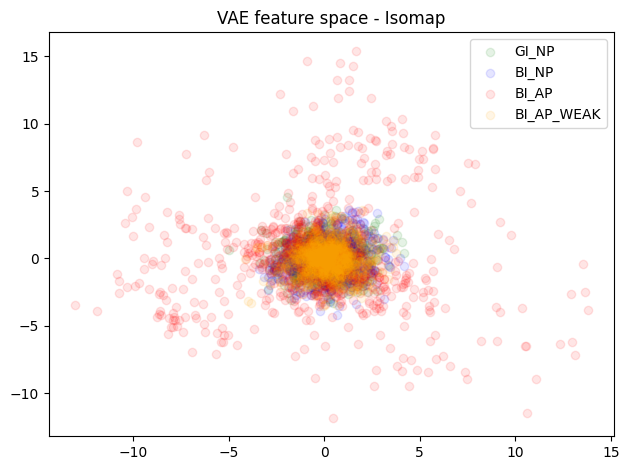

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for l in np.unique(total_labels):
    l = int(l.item())
    idxs = total_labels == l
    features = emb_features[idxs]
    ax.scatter(
        features[:,0],
        features[:,1],
        alpha=0.1,
        label=label_text[l],
        color=label_color[l]
    )
ax.legend()
ax.set_title("VAE feature space - Isomap")
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(save_path, "Isomap-embedding.png"))
# plt.close(fig)

In [49]:
from sklearn.manifold import Isomap, TSNE

transformer = TSNE(perplexity=100)
emb_features = transformer.fit_transform(total_features)

with open(os.path.join(save_path, "TNSE-features.pkl"), "wb") as f:
    pickle.dump(
        (emb_features, total_labels, label_text),
        f
    )


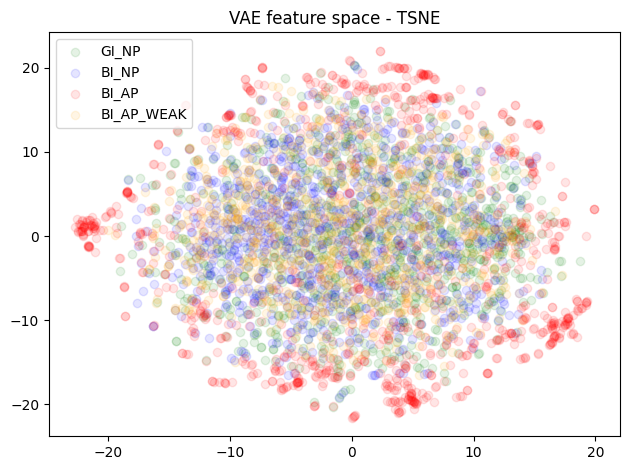

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for l in np.unique(total_labels):
    l = int(l.item())
    idxs = total_labels == l
    features = emb_features[idxs]
    ax.scatter(
        features[:,0],
        features[:,1],
        alpha=0.1,
        label=label_text[l],
        color=label_color[l]
    )
ax.legend()
ax.set_title("VAE feature space - TSNE")
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(save_path, "TSNE-embedding.png"))
# plt.close(fig)

In [1]:
import torch
device = torch.device("cuda")
x = torch.randn((10, 8))
y = torch.randint(0, 2, (10,))
print(x.shape)
print(x)
print(y.shape)
print(y)

torch.Size([10, 8])
tensor([[-0.6528, -0.9947,  0.6569, -0.4794, -0.0955, -0.5641, -0.0211,  0.1013],
        [-1.2576,  0.3937, -0.2306, -1.5507, -1.3644, -0.2868,  0.7362,  0.9936],
        [-0.3673,  0.4616, -0.1020,  0.1285, -0.9779,  0.2165, -1.1255,  0.8183],
        [ 1.0837,  0.7941, -1.4534,  0.3124,  2.0594,  1.1036,  0.2304,  0.2532],
        [ 0.6038, -0.8503, -1.1209, -2.5167, -0.9325, -0.8690,  0.8038, -0.3760],
        [-0.1095,  3.4983, -0.9611, -0.6801, -1.0632,  0.7086, -2.3656,  0.1615],
        [-0.6389, -0.6738, -0.6348,  0.4361,  0.4096,  0.8919, -0.2520, -0.7320],
        [ 0.3654,  0.3111, -0.0368, -0.5249,  1.5193,  0.2696, -0.3529,  0.6248],
        [-1.4015,  1.3056, -0.5606,  1.2968, -0.8181, -0.3131, -0.3052, -0.2083],
        [-1.2356,  0.6333,  0.4309, -0.7876, -1.3563, -0.4781, -0.8569, -0.8609]])
torch.Size([10])
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1])


In [2]:
anchor_id = 0
anchor = x[y==anchor_id]
positive = x[y==anchor_id]
negative = x[y!=anchor_id]

print("anchor")
print(anchor)
print("positive")
print(positive)
print("negative")
print(negative)

anchor
tensor([[-0.6528, -0.9947,  0.6569, -0.4794, -0.0955, -0.5641, -0.0211,  0.1013],
        [-1.2576,  0.3937, -0.2306, -1.5507, -1.3644, -0.2868,  0.7362,  0.9936],
        [ 0.6038, -0.8503, -1.1209, -2.5167, -0.9325, -0.8690,  0.8038, -0.3760],
        [-0.1095,  3.4983, -0.9611, -0.6801, -1.0632,  0.7086, -2.3656,  0.1615],
        [-0.6389, -0.6738, -0.6348,  0.4361,  0.4096,  0.8919, -0.2520, -0.7320],
        [-1.4015,  1.3056, -0.5606,  1.2968, -0.8181, -0.3131, -0.3052, -0.2083]])
positive
tensor([[-0.6528, -0.9947,  0.6569, -0.4794, -0.0955, -0.5641, -0.0211,  0.1013],
        [-1.2576,  0.3937, -0.2306, -1.5507, -1.3644, -0.2868,  0.7362,  0.9936],
        [ 0.6038, -0.8503, -1.1209, -2.5167, -0.9325, -0.8690,  0.8038, -0.3760],
        [-0.1095,  3.4983, -0.9611, -0.6801, -1.0632,  0.7086, -2.3656,  0.1615],
        [-0.6389, -0.6738, -0.6348,  0.4361,  0.4096,  0.8919, -0.2520, -0.7320],
        [-1.4015,  1.3056, -0.5606,  1.2968, -0.8181, -0.3131, -0.3052, -0.2083]]

In [3]:
dist_pos = torch.cdist(anchor, positive)
dist_neg = torch.cdist(anchor, negative)
print(dist_pos)
print(dist_neg)

tensor([[0.0000, 2.6991, 3.2578, 5.5854, 2.3943, 3.3542],
        [2.6991, 0.0000, 3.0239, 4.8625, 3.7581, 3.4493],
        [3.2578, 3.0239, 0.0000, 5.9714, 4.0834, 5.0106],
        [5.5854, 4.8625, 5.9714, 0.0000, 5.1485, 4.0039],
        [2.3943, 3.7581, 4.0834, 5.1485, 0.0000, 2.9124],
        [3.3542, 3.4493, 5.0106, 4.0039, 2.9124, 0.0000]])
tensor([[2.5039, 4.3367, 2.6290, 2.5214],
        [2.7446, 5.0069, 3.6984, 2.6630],
        [4.1266, 4.9615, 4.0244, 3.7825],
        [3.5914, 5.1592, 4.7318, 4.0301],
        [2.6998, 3.1269, 2.5941, 3.1742],
        [2.3216, 4.3579, 3.7687, 2.6181]])


In [5]:
further_pos = torch.argmax(dist_pos, dim=1)
max_dist_pos = torch.max(dist_pos, dim=1)
print(further_pos)
print(max_dist_pos)

tensor([3, 3, 3, 2, 3, 2])
torch.return_types.max(
values=tensor([5.5854, 4.8625, 5.9714, 5.9714, 5.1485, 5.0106]),
indices=tensor([3, 3, 3, 2, 3, 2]))


In [ ]:
closer_neg = dist_neg < torch.max(dist_pos, dim=1)